# Stylized Facts for Assets Returns

A stylized fact is a term that is used for a generalization which summarizes data. Any stylized fact will essentially be true - hence a fact - yet there may be some inconsistencies.

A good example is "Education significantly raises lifetime income". Broadly speaking, this fact holds true, however, in many cases people with PhDs endup with low paying jobs. This is because PhDs normally go into academia.

These facts have to be present in every model. Every financial model should follow these facts to be considered useful.

## The five stylized facts

I will be discussing these facts in more detail when analyzing the data.
1. The returns are not normally distributed.
2. Highly variable returns or high volatility periods are usually clustered.
3. The returns are not autocorrelated over long time periods.
4. Squared or absolute returns will show declining and small autocorrelations over long time periods.
5. The volatility (variations in returns) are inversely related to price trends. The higher the prices go, the lesser the variability in return.

## The dataset

I will be using S&P500 data extracting it from Yahoo.

## Importing the libraries and creating the dataset

In [1]:
# libraries for data processing
import pandas as pd
import numpy as np
import math

# libraries for visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

# library for profiling the dataframe
import pandas_profiling as df_profiler

# library for statistical analysis - for creating normal plot
import scipy.stats as pystats

# library for accessing qqplot functionality
import statsmodels.api as sm

# library for accessing the autocorrelation functionality
import statsmodels.tsa.api as smt

# library for extracting financial data
from yahoofinancials import YahooFinancials


# extracting S&P500 data
ticker = '^GSPC'
start_date = '1990-05-01'
end_date = '2020-05-31'
yahoo_financials = YahooFinancials( ticker )
prices = yahoo_financials.get_historical_price_data( start_date, end_date, 'daily' )

# converting the data to pandas dataframe
df = pd.DataFrame( prices[ticker]['prices'] )

# setting proper index
df[ 'date' ] = pd.to_datetime( df[ 'formatted_date' ] )
df.set_index( df[ 'date' ], inplace = True )

# creating log returns
df[ 'log_returns' ] = np.log( df[ 'adjclose' ]/df[ 'adjclose' ].shift(1) )
df[ 'log_returns_pct' ] = df[ 'log_returns' ] * 100

# keeping only relevant columns
columns_to_keep = [ 'adjclose', 'log_returns', 'log_returns_pct' ]
df = df[ columns_to_keep ]

print( df.head(5) )

              adjclose  log_returns  log_returns_pct
date                                                
1990-05-01  332.250000          NaN              NaN
1990-05-02  334.480011     0.006689         0.668942
1990-05-03  335.570007     0.003253         0.325348
1990-05-04  338.390015     0.008369         0.836852
1990-05-07  340.529999     0.006304         0.630410


The following cell does profiling of the dataset. I am using a library called "pandas_profiling" to do some speedy analysis.

In [2]:
# Profiling the dataset
df_profiler.ProfileReport( df )

Note that raw returns have no particular shape. However, looking at log returns we see a shape. In the next, first fact, I am going to explore more of the log returns distribution.

In [3]:
# Deleting the rows with NAN
df = df.dropna()

## Fact 1: Shape of the distribution of returns is not normal

First step in understanding the shape of the log returns is to create a dataset that would store the data in form of normal distribution. To do this need to calculate the average and standard deviation of the log returns. I am going to use the data to create a visualization using plotly.

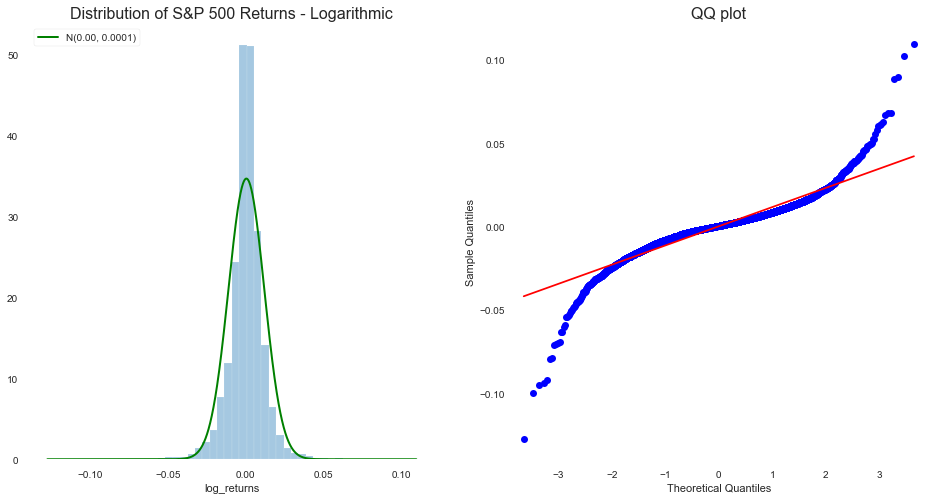

In [4]:
# calculating minimum and maximum values of the dataset to create an array that would help in visualization.
min_log_ret = min( df[ 'log_returns' ] )
max_log_ret = max( df[ 'log_returns' ] )
data_range = np.linspace( min_log_ret, max_log_ret, num = 10000 )

# calculating mean and standard deviation of the dataset
mu_log_ret = df[ 'log_returns' ].mean()
sigma_log_ret = df[ 'log_returns' ].std()

# creating the normal probability density function
normal_pdf = pystats.norm.pdf( data_range, loc = mu_log_ret, scale = sigma_log_ret )

# setting up the plot
fig, ax = plt.subplots( 1, 2, figsize = ( 16, 8 ) )

# plotting the histogram
sns.distplot( df[ 'log_returns' ], kde = False, norm_hist = True, ax = ax[ 0 ] )
ax[ 0 ].set_title( 'Distribution of S&P 500 Returns - Logarithmic', fontsize = 16 )
ax[ 0 ].plot( data_range, normal_pdf, 'g', lw = 2, label = f'N({mu_log_ret:.2f}, {sigma_log_ret**2:.4f})' )
ax[ 0 ].legend( loc = 'upper left' )

# plotting the QQ plot
qqplot = sm.qqplot( df[ 'log_returns' ], line = 's', ax = ax[ 1 ] )
ax[ 1 ].set_title( 'QQ plot', fontsize = 16 )

# displaying the plot
plt.show()

To understand the output, it is important to see some important statistics about the logarithmic returns. The following piece of code does that.

In [5]:
print( '===================================================================' )
print( '                       Descriptive Statistics                      ' )
print( '===================================================================' )
print( 'Total number of rows in the dataframe:', f"{df.shape[ 0 ]:,}" )
print( 'Mean:', f"{df[ 'log_returns' ].mean():.6f}" )
print( 'Median:', f"{df[ 'log_returns' ].median():.6f}" )
print( 'Standard Deviation:', f"{df[ 'log_returns' ].std():.6f}" )
print( 'Skewness:', f"{df[ 'log_returns' ].skew():.6f}" )
print( 'Kurtosis:', f"{df[ 'log_returns' ].kurtosis():.6f}" )

                       Descriptive Statistics                      
Total number of rows in the dataframe: 7,578
Mean: 0.000292
Median: 0.000552
Standard Deviation: 0.011516
Skewness: -0.389591
Kurtosis: 11.539559


Seeing skewness as negative and seeing distribution, I can interpret that negative returns occur slightly more than positive returns. 

Note that kurtosis is higher than 1 which indicates the presence of high number of outliers. 

The QQ plot has the shape has tails that are very far from the red line. This corroborates the higher kurtosis. 

There is one final test that checks the null hypothesis that a particular distribution is normally shaped.

In [6]:
jarque_bera_statistic = pystats.jarque_bera( df[ 'log_returns' ] )
print( '===================================================================' )
print( '              Jarque Bera Statistic for Normality                  ' )
print( '===================================================================' )
print(f'Jarque-Bera statistic: {jarque_bera_statistic[ 0 ]:.3f} with p-value: {jarque_bera_statistic[ 1 ]:.3f}')

              Jarque Bera Statistic for Normality                  
Jarque-Bera statistic: 42176.121 with p-value: 0.000


With Jarque_Bera p-value less than 0.05, we comfortably reject the null hypothesis that log returns are normally distributed.

#### Conclusion

Based on the analysis and statistical testing, we can confidently confirm that returns are skewed. Negative returns are more likely to happen during the time period of analysis. Note that the time period is historical.

## Fact 2: Volatility in returns is in clusters

Best way of understanding the volatility is visualizing the trends in returns. Following code creates such a visualization.

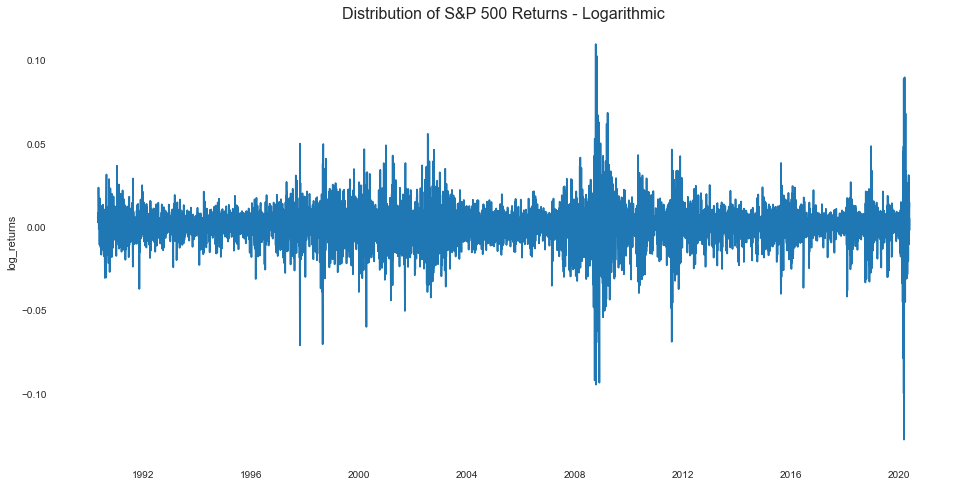

In [7]:
fig, ax = plt.subplots( 1, 1, figsize = ( 16, 8 ) )

# plotting the lineplot
sns.lineplot( x = df.index.date, y = df[ 'log_returns' ] )
plt.title( 'Distribution of S&P 500 Returns - Logarithmic', fontsize = 16 )
plt.show()

#### Conclusion

As seen in the plot, there are 3 main regions of volatility. The first region is from 1997 till 2004. The next region of volatility cluster is between 2008 and 2012. The last volatility cluster has started in 2020. I can immediately see that volatility happens in chunks of periods.

## Fact 3: There is no autocorrelation in returns

First thing to understand is autocorrelation and since I am working with time series data, this concept is critical. Autocorrrelation allows comparison of current time's value with the past values. The best way to understand correlation is to visualize it.

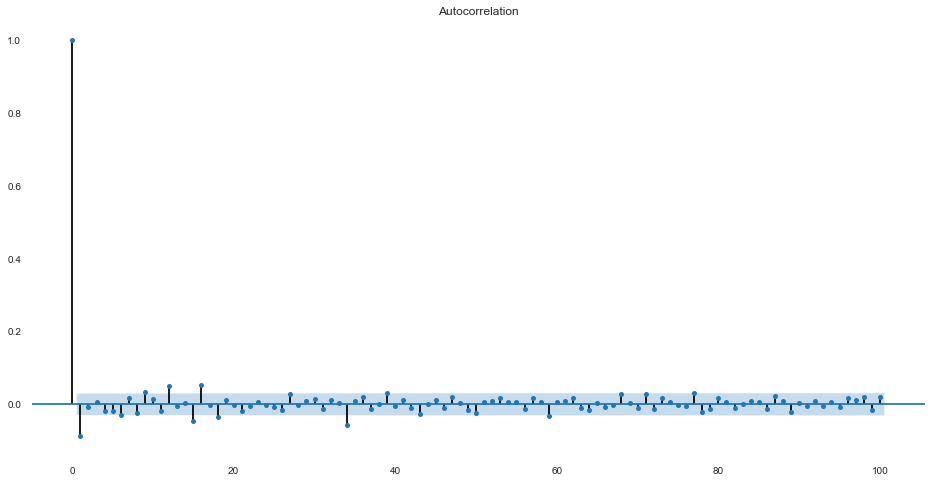

In [8]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 8]

# setting up parameters for autocorrelations
N_LAGS = 100
SIGNIFICANCE_LEVEL = 0.01

# creating the plot
acf = smt.graphics.plot_acf( df[ 'log_returns' ], lags = N_LAGS, alpha = SIGNIFICANCE_LEVEL )
plt.show()

The first line is for 0 lag. At the same time period, there has to be highest correlation. Lagged for 100 days, I see that there are some points that beyond the shadded region, indicating some significance. Otherwise, I can see that there is no correlation in the returns.

#### Conclusion

As seen in the previous graph, I can easily confirm this fact that the returns have no autocorrelations.

## Fact 4: Squaring the returns or taking the absolute values of returns lead to declining or small returns

This fact is best understood by visualizing it. The following cell plots 2 graphs. The first graph plots squared logarithmic returns. The next graph plots absolute logrithmic returns.

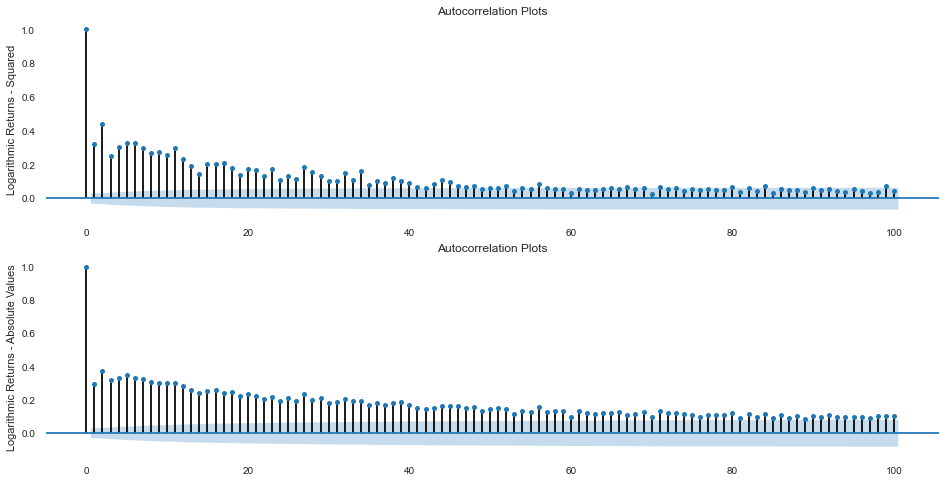

In [9]:
# setting the plot area
fig, ax = plt.subplots( 2, 1, figsize = ( 16, 8 ) )

# creating the first plot
smt.graphics.plot_acf( df[ 'log_returns' ]**2, lags = N_LAGS, alpha = SIGNIFICANCE_LEVEL, ax = ax[ 0 ] )
ax[ 0 ].set( title = 'Autocorrelation Plots', ylabel = 'Logarithmic Returns - Squared' )

# creating the second plot
smt.graphics.plot_acf( np.abs( df[ 'log_returns' ] ), lags = N_LAGS, alpha = SIGNIFICANCE_LEVEL, ax = ax[ 1 ] )
ax[ 1 ].set( title = 'Autocorrelation Plots', ylabel = 'Logarithmic Returns - Absolute Values' )

# display the plot
plt.show()

While most of the points in both charts are above the significance, their autocorrelation is still very small and declining.

#### Conclusion

The squared and absolute algorithmic returns are declining and small. This fact has been substantiated by the above two graphs.

Both types of autocorrelations are important. Simple logarithmic returns are either negative or positive. This makes it logically to understand how far away the returns are from the mean, for example. Calculating either absolute or squared of logarithmic returns removes this issue.

## Fact 5: Leverage effect - The higher the volatility in assets, the lower the returns

To visualize this fact, I will be plotting three graphs. 

The first plot is the adjusted close plot.

The second plot is that of logarithmic returns.

It is important to understand that understanding relationship between volatility and returns on daily basis would be very problematic. Therefore, I will be taking standard deviations on rolling basis.

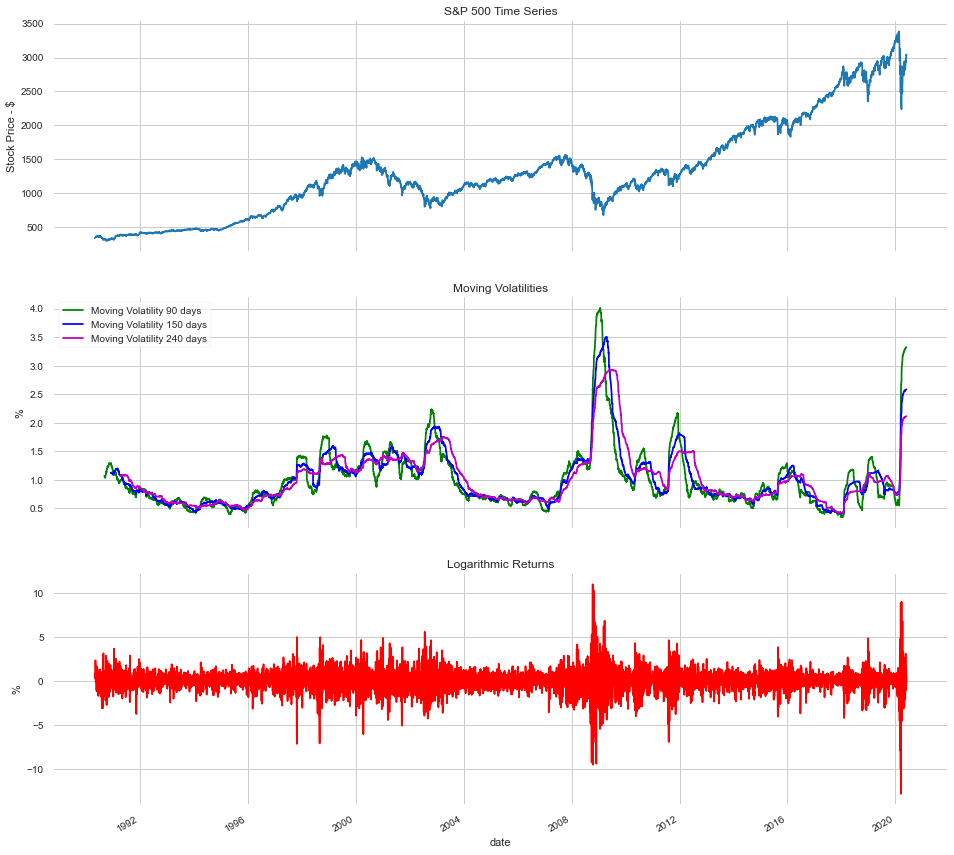

In [10]:
# creating rolling standard deviations
df[ 'std_rolling_90' ] = df[ [ 'log_returns_pct' ] ].rolling( window = 90 ).std()
df[ 'std_rolling_150' ] = df[ [ 'log_returns_pct' ] ].rolling( window = 150 ).std()
df[ 'std_rolling_240' ] = df[ [ 'log_returns_pct' ] ].rolling( window = 240 ).std()

# creating the plots canvas
fig, ax = plt.subplots( 3, 1, figsize = ( 16, 16 ), sharex = True )

# plotting the adjusted closed prices
df[ 'adjclose' ].plot( ax = ax[ 0 ] )
ax[ 0 ].set( title = 'S&P 500 Time Series', ylabel = 'Stock Price - $' )
ax[ 0 ].grid()

# plotting the logarithmic returns in percent
df[ 'log_returns_pct' ].plot( ax = ax[ 2 ], color = 'r' )
ax[ 2 ].set( title = 'Logarithmic Returns', ylabel = '%' )
ax[ 2 ].grid()

# plotting rolling standard deviations
df[ 'std_rolling_90' ].plot( ax = ax[ 1 ], color = 'g', label = 'Moving Volatility 90 days')
df[ 'std_rolling_150' ].plot( ax = ax[ 1 ], color = 'b', label = 'Moving Volatility 150 days')
df[ 'std_rolling_240' ].plot( ax = ax[ 1 ], color = 'm', label = 'Moving Volatility 240 days')
ax[ 1 ].set( title = 'Moving Volatilities', ylabel = '%', xlabel = 'Date' )
ax[ 1 ].legend()
ax[ 1 ].grid()


plt.show()

#### Conclusion

It is clearly observable that when the prices start to go up, the volatility starts going down.